In [ ]:
###########################################################
#### CHAPTER 4: SUHI FEATURES AND INFLUENCE OF CLIMATE ####
###########################################################

# Code for producing figures to be used #

In [45]:
# Import required packages
 
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import earthpy as et
import pandas as pd
import pickle
import matplotlib.patches as mpatches
import seaborn as sns

# Read in the data

# city info table
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=None)

#remove cities with area of less than 10km2
CITY_COUNTRY_lat_lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['Area_2002']>9].reset_index()

# add in city, country column
CITY_COUNTRY_lat_lon['City, Country'] = CITY_COUNTRY_lat_lon['City'] + ', ' + CITY_COUNTRY_lat_lon['Country']

# table with all variables
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
with open('aqua_all_monthly_data_df2.pkl', 'rb') as f:
    all_monthly_data_df = pickle.load(f)
    
    
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))

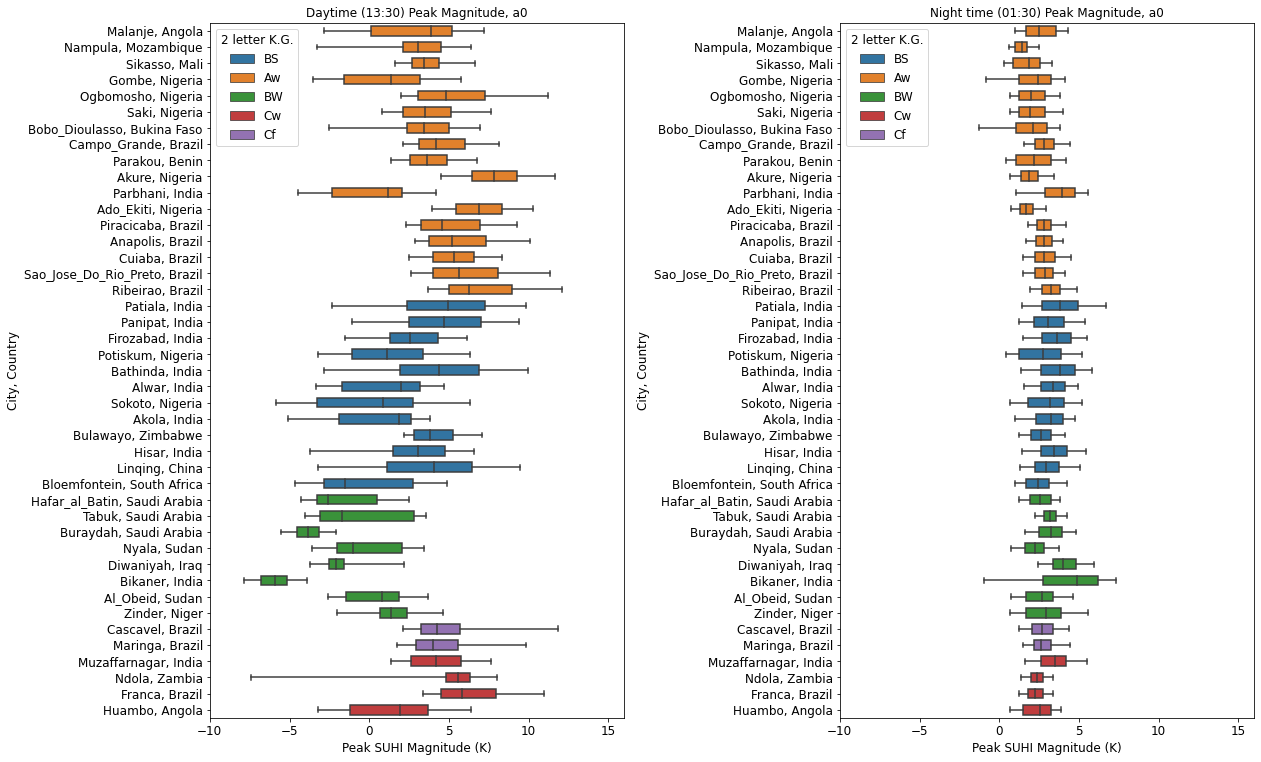

In [46]:
# Box plots

#set the font sizes
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

#for aqua day

fig, axes = plt.subplots(1,2, figsize = (20, 15))
fig.tight_layout(pad=15.0)
#fig.suptitle("Peak Magnitude")
#plt.subplots_adjust(top=0.94) # move subplot title position

#import the required package for normalising 
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

#koppen geiger first letters for hue
CITY_COUNTRY_lat_lon['Koppen Geiger 1 Letter'] = CITY_COUNTRY_lat_lon['koppen_climate'].astype(str).str[0]
#koppen geiger first 2 letters
CITY_COUNTRY_lat_lon['Koppen Geiger 2 Letter'] = CITY_COUNTRY_lat_lon['koppen_climate'].astype(str).str[0:2]

#loop through cities and plot on the axes
for i in range(len(CITY_COUNTRY_lat_lon)):
    CITY_COUNTRY = CITY_COUNTRY_lat_lon['CITY_COUNTRY'][i] 
    city_name = CITY_COUNTRY_lat_lon['City, Country'][i]   
    one_letter_koppen_geiger = CITY_COUNTRY_lat_lon['Koppen Geiger 1 Letter'][i]
    two_letter_koppen_geiger = CITY_COUNTRY_lat_lon['Koppen Geiger 2 Letter'][i]
    
    SATELLITE = 'MYD11A2' #AQUA
    os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))
    
    pickle_name = 'Parameters_Day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        aqua_parameters_day = pickle.load(f)
    pickle_name = 'Parameters_Night_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        aqua_parameters_night = pickle.load(f)       
        
    aqua_parameters_day.rename(columns = {'day_a0':'a0'}, inplace = True)
    aqua_parameters_night.rename(columns = {'night_a0':'a0'}, inplace = True)

    aqua_parameters_day['City, Country'] = city_name
    aqua_parameters_day['one_letter_koppen_geiger'] = one_letter_koppen_geiger
    aqua_parameters_day['two_letter_koppen_geiger'] = two_letter_koppen_geiger
    
    aqua_parameters_night['City, Country'] = city_name
    aqua_parameters_night['one_letter_koppen_geiger'] = one_letter_koppen_geiger
    aqua_parameters_night['two_letter_koppen_geiger'] = two_letter_koppen_geiger
    
    if i == 0:
        cdf_day = aqua_parameters_day
        cdf_night = aqua_parameters_night
    else:
        cdf_day = pd.concat([cdf_day, aqua_parameters_day])  # concatonate
        cdf_night = pd.concat([cdf_night, aqua_parameters_night])

#set the order to plot the cities in               
city_plot_order = CITY_COUNTRY_lat_lon.sort_values('koppen_climate')['City, Country'].values

#plot the daytime
#quantile_a0
plotnum = 0

sns.boxplot(ax = axes[plotnum], x="a0", y="City, Country", data=cdf_day, hue = "two_letter_koppen_geiger", width = 0.6
            ,dodge =False, hue_order = set(CITY_COUNTRY_lat_lon['Koppen Geiger 2 Letter']), order = city_plot_order, 
            showfliers = False, whis=[5, 95]) 
#create plot, alt hue order ["A","B","C"]

axes[plotnum].set_title('Daytime (13:30) Peak Magnitude, a0')
axes[plotnum].set(xlim=(-10, 16), xlabel = 'Peak SUHI Magnitude (K)')
axes[plotnum].legend(loc='upper left', title = '2 letter K.G.')

#plot the nighttime
#a0
plotnum = 1 

sns.boxplot(ax = axes[plotnum], x="a0", y="City, Country", data=cdf_night, hue = "two_letter_koppen_geiger", width = 0.6
            ,dodge =False, hue_order = set(CITY_COUNTRY_lat_lon['Koppen Geiger 2 Letter']), order = city_plot_order, 
            showfliers = False, whis=[5, 95]) #create plot 
axes[plotnum].set_title('Night time (01:30) Peak Magnitude, a0')
axes[plotnum].set(xlim=(-10, 16), xlabel = 'Peak SUHI Magnitude (K)')
axes[plotnum].legend(loc='upper left', title = '2 letter K.G.')

#save plot
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'Graphs_outputs'
                      , 'SUHI_characteristics_4_overpasses'))
plt.savefig('gsa_a0_all_cities.png')

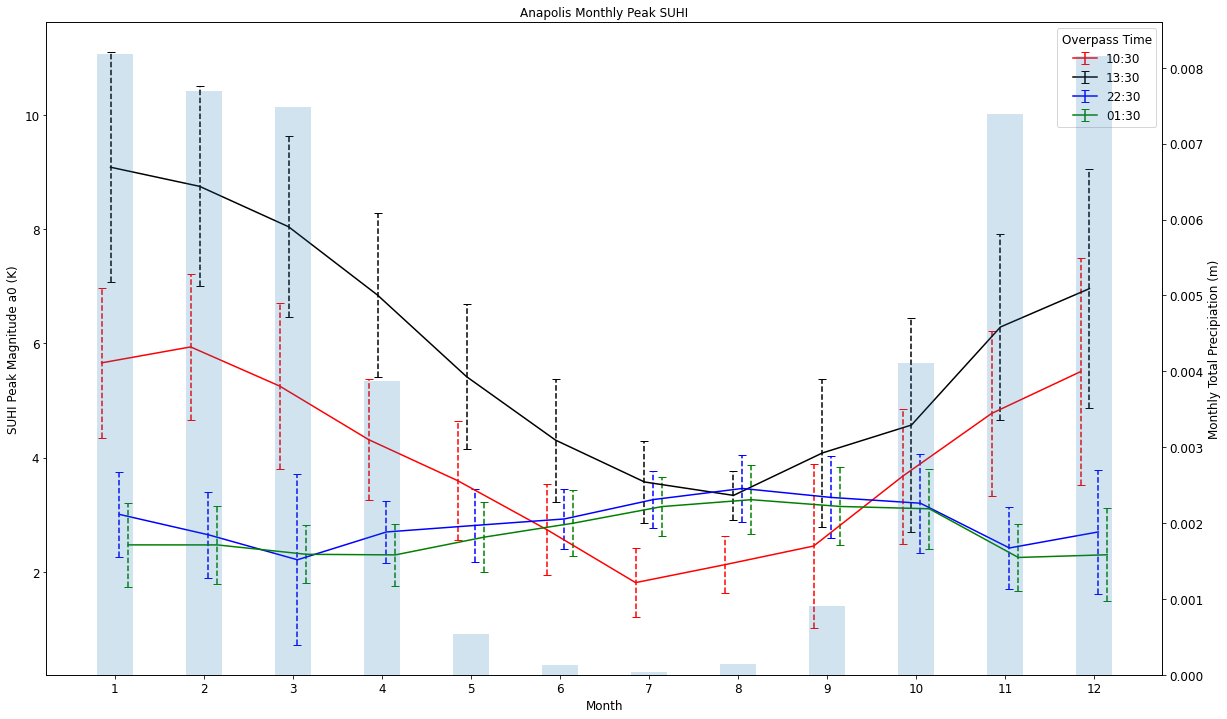

In [69]:
# Select a individual city and plot with tp bars

CITY_COUNTRY = 'ANAPOLIS_BRAZIL'
city_name = 'Anapolis' 

#create seasonal plots (4 overpasses averaged by month with stds)
#same as plot about but for the max SUHI, a0

#import affine 2D for the transformations (to offset error bars)
from matplotlib.transforms import Affine2D

#create the axes the add the plots to 
fig, axes = plt.subplots(1,1, figsize = (20, 12))
#fig.tight_layout(pad=8.0)
#fig.suptitle("Peak SUHI (K) with relative humidity bars")
#plt.subplots_adjust(top=0.96)
mons = ['1','2','3','4','5','6','7','8','9','10','11','12']

#read in parameters table
SATELLITE = 'MOD11A2' #TERRA
os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))

pickle_name = 'Parameters_Day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
with open(pickle_name, 'rb') as f:
    terra_parameters_day = pickle.load(f)
pickle_name = 'Parameters_Night_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
with open(pickle_name, 'rb') as f:
    terra_parameters_night = pickle.load(f)

SATELLITE = 'MYD11A2' #AQUA
os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))
    
pickle_name = 'Parameters_Day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
with open(pickle_name, 'rb') as f:
    aqua_parameters_day = pickle.load(f)
pickle_name = 'Parameters_Night_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
with open(pickle_name, 'rb') as f:
    aqua_parameters_night = pickle.load(f)       
        
terra_parameters_day.rename(columns = {'day_a0':'a0'}, inplace = True)
terra_parameters_night.rename(columns = {'night_a0':'a0'}, inplace = True)
aqua_parameters_day.rename(columns = {'day_a0':'a0'}, inplace = True)
aqua_parameters_night.rename(columns = {'night_a0':'a0'}, inplace = True)
#group the parameters by month then plot each overpass

terra_parameters_day_avgs = terra_parameters_day.groupby(['Month']).aggregate({"a0":np.mean, "method_2_SUHI":np.mean, 
                                                                             "footprint_area":np.mean})

terra_parameters_day_stds = terra_parameters_day.groupby(['Month']).aggregate({"a0":np.std, "method_2_SUHI":np.std, 
                                                                             "footprint_area":np.std})

aqua_parameters_day_avgs = aqua_parameters_day.groupby(['Month']).aggregate({"a0":np.mean, "method_2_SUHI":np.mean, 
                                                                             "footprint_area":np.mean})

aqua_parameters_day_stds = aqua_parameters_day.groupby(['Month']).aggregate({"a0":np.std, "method_2_SUHI":np.std, 
                                                                             "footprint_area":np.std})
    
terra_parameters_night_avgs = terra_parameters_night.groupby(['Month']).aggregate({"a0":np.mean, "method_2_SUHI":np.mean, 
                                                                             "footprint_area":np.mean})

terra_parameters_night_stds = terra_parameters_night.groupby(['Month']).aggregate({"a0":np.std, "method_2_SUHI":np.std, 
                                                                             "footprint_area":np.std})
    
aqua_parameters_night_avgs = aqua_parameters_night.groupby(['Month']).aggregate({"a0":np.mean, "method_2_SUHI":np.mean, 
                                                                             "footprint_area":np.mean})

aqua_parameters_night_stds = aqua_parameters_night.groupby(['Month']).aggregate({"a0":np.std, "method_2_SUHI":np.std, 
                                                                             "footprint_area":np.std})

rural_tp_df = all_monthly_data_df[(all_monthly_data_df['City'] == city_name) & (all_monthly_data_df['Overpass'] == '13:30'
                                )].groupby(['month']).aggregate({"rural_tp":np.mean})

axtwin = axes.twinx()
    
axtwin.bar(mons, rural_tp_df.rural_tp, width = 0.4, alpha = 0.2)
#axtwin.set_ylim([50,100])
axtwin.set_ylabel('Monthly Total Precipiation (m)')
      
    
#plot with error bars
trans1 = Affine2D().translate(-0.15, 0.0) + axes.transData
trans2 = Affine2D().translate(-0.05, 0.0) + axes.transData 
trans3 = Affine2D().translate(+0.05, 0.0) + axes.transData
trans4 = Affine2D().translate(+0.15, 0.0) + axes.transData 
    
    
p1 = axes.errorbar(mons, terra_parameters_day_avgs.a0, 
                                   yerr = terra_parameters_day_stds.a0, color = 'red', label = '10:30'
                                  ,transform = trans1, capsize = 4)  #create plot 
p2 = axes.errorbar(mons, aqua_parameters_day_avgs.a0, 
                                   yerr = aqua_parameters_day_stds.a0,color = 'black', label = '13:30'
                                  ,transform = trans2, capsize = 4)
p3 = axes.errorbar(mons, terra_parameters_night_avgs.a0,
                                   yerr = terra_parameters_night_stds.a0, color = 'blue', label = '22:30'
                                  ,transform = trans3, capsize = 4)
p4 = axes.errorbar(mons, aqua_parameters_night_avgs.a0,
                                   yerr = aqua_parameters_night_stds.a0, color = 'green', label = '01:30'
                                  ,transform = trans4, capsize = 4)    
    
    
axes.set_title('{} Monthly Peak SUHI'.format(city_name))
axes.set_xlabel('Month')
axes.set_ylabel('SUHI Peak Magnitude a0 (K)')
axes.legend(title = 'Overpass Time')
p1[-1][0].set_linestyle('--') # [-1][0] is LineCollection objects of the errorbar lines. set error bar linestyle
p2[-1][0].set_linestyle('--')
p3[-1][0].set_linestyle('--')
p4[-1][0].set_linestyle('--')
    
#save plot to chpt 4 folder
os.chdir(os.path.join(et.io.HOME, 'Documents','UEA','Urban_Heat','PROJECT','Writing_up',
                      'Chapter_4_Features_SUHI_Influence_Climate','figures'))
plt.savefig('Anapolis.png')


In [57]:
# Plots for all the cities
#create seasonal plots (4 overpasses averaged by month with stds)
#import affine 2D for the transformations (to offset error bars)
from matplotlib.transforms import Affine2D

#create the axes the add the plots to 
fig, axes = plt.subplots(10,2, figsize = (20, 50))
fig.tight_layout(pad=8.0)
fig.suptitle("Peak SUHI magnitude, a0 (K) for each city, with total precipitation bars")
plt.subplots_adjust(top=0.96)
mons = ['1','2','3','4','5','6','7','8','9','10','11','12']

#loop through cities and plot on the axes
for i in range(len(CITY_COUNTRY_lat_lon)):
    CITY_COUNTRY = CITY_COUNTRY_lat_lon['CITY_COUNTRY'][i] 
    city_name = CITY_COUNTRY_lat_lon['City'][i]   
    
    #read in parameters table
    SATELLITE = 'MOD11A2' #TERRA
    os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))

    pickle_name = 'Parameters_Day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        terra_parameters_day = pickle.load(f)
    pickle_name = 'Parameters_Night_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        terra_parameters_night = pickle.load(f)

    SATELLITE = 'MYD11A2' #AQUA
    os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))
    
    pickle_name = 'Parameters_Day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        aqua_parameters_day = pickle.load(f)
    pickle_name = 'Parameters_Night_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        aqua_parameters_night = pickle.load(f)       
        
    terra_parameters_day.rename(columns = {'day_a0':'a0'}, inplace = True)
    terra_parameters_night.rename(columns = {'night_a0':'a0'}, inplace = True)
    aqua_parameters_day.rename(columns = {'day_a0':'a0'}, inplace = True)
    aqua_parameters_night.rename(columns = {'night_a0':'a0'}, inplace = True)
    #group the parameters by month then plot each overpass

    terra_parameters_day_avgs = terra_parameters_day.groupby(['Month']).aggregate({"a0":np.mean, "method_2_SUHI":np.mean, 
                                                                             "footprint_area":np.mean})

    terra_parameters_day_stds = terra_parameters_day.groupby(['Month']).aggregate({"a0":np.std, "method_2_SUHI":np.std, 
                                                                             "footprint_area":np.std})

    aqua_parameters_day_avgs = aqua_parameters_day.groupby(['Month']).aggregate({"a0":np.mean, "method_2_SUHI":np.mean, 
                                                                             "footprint_area":np.mean})

    aqua_parameters_day_stds = aqua_parameters_day.groupby(['Month']).aggregate({"a0":np.std, "method_2_SUHI":np.std, 
                                                                             "footprint_area":np.std})
    
    terra_parameters_night_avgs = terra_parameters_night.groupby(['Month']).aggregate({"a0":np.mean, "method_2_SUHI":np.mean, 
                                                                             "footprint_area":np.mean})

    terra_parameters_night_stds = terra_parameters_night.groupby(['Month']).aggregate({"a0":np.std, "method_2_SUHI":np.std, 
                                                                             "footprint_area":np.std})
    
    aqua_parameters_night_avgs = aqua_parameters_night.groupby(['Month']).aggregate({"a0":np.mean, "method_2_SUHI":np.mean, 
                                                                             "footprint_area":np.mean})

    aqua_parameters_night_stds = aqua_parameters_night.groupby(['Month']).aggregate({"a0":np.std, "method_2_SUHI":np.std, 
                                                                             "footprint_area":np.std})
    
    rural_tp_df = all_monthly_data_df[(all_monthly_data_df['City'] == city_name) & (all_monthly_data_df['Overpass'] == '13:30'
                                )].groupby(['month']).aggregate({"rural_tp":np.mean})
    
    if i%2 == 0:
        plotrow = int(i/2)
    else:
        plotrow = int((i-1)/2)
        
    plotcol = i%2       

    axtwin = axes[plotrow,plotcol].twinx()
    
    axtwin.bar(mons, city_rh, width = 0.4, alpha = 0.2)
    #axtwin.set_ylim([50,100])
    axtwin.set_ylabel('Monthly Total Precipitation (m)')   
    
    #plot with error bars
    trans1 = Affine2D().translate(-0.15, 0.0) + axes[plotrow,plotcol].transData
    trans2 = Affine2D().translate(-0.05, 0.0) + axes[plotrow,plotcol].transData 
    trans3 = Affine2D().translate(+0.05, 0.0) + axes[plotrow,plotcol].transData
    trans4 = Affine2D().translate(+0.15, 0.0) + axes[plotrow,plotcol].transData 
    
    
    p1 = axes[plotrow,plotcol].errorbar(mons, terra_parameters_day_avgs.a0, 
                                   yerr = terra_parameters_day_stds.a0, color = 'red', label = '10:30'
                                  ,transform = trans1, capsize = 4)  #create plot 
    p2 = axes[plotrow,plotcol].errorbar(mons, aqua_parameters_day_avgs.a0, 
                                   yerr = aqua_parameters_day_stds.a0,color = 'black', label = '13:30'
                                  ,transform = trans2, capsize = 4)
    p3 = axes[plotrow,plotcol].errorbar(mons, terra_parameters_night_avgs.a0,
                                   yerr = terra_parameters_night_stds.a0, color = 'blue', label = '22:30'
                                  ,transform = trans3, capsize = 4)
    p4 = axes[plotrow,plotcol].errorbar(mons, aqua_parameters_night_avgs.a0,
                                   yerr = aqua_parameters_night_stds.a0, color = 'green', label = '01:30'
                                  ,transform = trans4, capsize = 4)    
    
    
    axes[plotrow,plotcol].set_title('{} Monthly Peak SUHI Magnitude a0'.format(city_name))
    axes[plotrow,plotcol].set_xlabel('Month')
    axes[plotrow,plotcol].set_ylabel('Peak SUHI Magnitude a0 (K)')
    axes[plotrow,plotcol].legend(title = 'Overpass Time')
    p1[-1][0].set_linestyle('--') # [-1][0] is LineCollection objects of the errorbar lines. set error bar linestyle
    p2[-1][0].set_linestyle('--')
    p3[-1][0].set_linestyle('--')
    p4[-1][0].set_linestyle('--')
    
#save plot to chpt 4 folder
os.chdir(os.path.join(et.io.HOME, 'Documents','UEA','Urban_Heat','PROJECT','Writing_up',
                      'Chapter_4_Features_SUHI_Influence_Climate','figures'))
plt.savefig('seasonality_TP_all_cities.png')

In [77]:
aqua_parameters_day_avgs.a0.values

array([9.0831737 , 8.74879403, 8.0420093 , 6.84621687, 5.41965428,
       4.30888698, 3.57634564, 3.34146021, 4.0846922 , 4.57279965,
       6.28807767, 6.95936117])

In [75]:
import scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

Amplitude=0.5942414641315715, Angular freq.=0.5640113853906659, phase=-0.9576699002116738, offset=5.880597205249485, Max. Cov.=0.7191469811483047


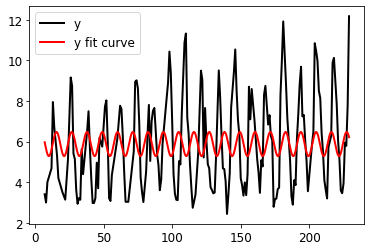

In [137]:
import pylab as plt

month = list(map(int, mons))
#tt = np.array(month)
#yy = aqua_parameters_day_avgs.a0.values
#tt2 = np.linspace(1, 12, 1000)

tt = aqua_day_yy_mm.month_count.values
yy = aqua_day_yy_mm.a0.values
tt2 = np.linspace(min(tt), max(tt), 10000)

res = fit_sin(tt, yy)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

plt.plot(tt, yy, "-k", label="y", linewidth=2)
#plt.plot(tt, yynoise, "ok", label="y with noise")
plt.plot(tt2, res["fitfunc"](tt2), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.show()

In [89]:
month = list(map(int, mons))
tt = np.array(month)
yy = aqua_parameters_day_avgs.a0.values
fit_sin(tt, yy)

{'amp': 2.819670218990082,
 'omega': 0.4616810626070932,
 'phase': 1.1064525432862498,
 'offset': 6.2459321933450545,
 'freq': 0.07347882324583768,
 'period': 13.609363294432542,
 'fitfunc': <function __main__.fit_sin.<locals>.<lambda>(t)>,
 'maxcov': 0.015386087630843068,
 'rawres': (array([2.73101783, 0.52359878, 0.        , 5.93928931]),
  array([2.81967022, 0.46168106, 1.10645254, 6.24593219]),
  array([[ 0.00888114, -0.00067477,  0.00556668,  0.00484291],
         [-0.00067477,  0.0002417 , -0.00187803, -0.00143755],
         [ 0.00556668, -0.00187803,  0.01538609,  0.01137347],
         [ 0.00484291, -0.00143755,  0.01137347,  0.01188167]]))}

In [126]:
aqua_day_yy_mm = aqua_parameters_day.groupby(['Year','Month']).aggregate({"a0":np.mean, "method_2_SUHI":np.mean, 
                                                                             "footprint_area":np.mean}).reset_index()


# get rid of dp 
aqua_day_yy_mm['Year'] = list(map(int, aqua_day_yy_mm['Year']))
aqua_day_yy_mm['Month'] = list(map(int, aqua_day_yy_mm['Month']))

# convert to string
aqua_day_yy_mm['Year_str'] = list(map(str, aqua_day_yy_mm['Year']))
aqua_day_yy_mm['Month_str'] = list(map(str, aqua_day_yy_mm['Month']))

# add in 0 for months less than 10  
aqua_day_yy_mm.loc[aqua_day_yy_mm['Month'] < 10, 'Month_str'] = '0' + aqua_day_yy_mm['Month_str']

# add yyyymm string 
aqua_day_yy_mm['yyyy_mm'] = aqua_day_yy_mm['Year_str'] + aqua_day_yy_mm['Month_str']

# add month count column
aqua_day_yy_mm['month_count'] = ((aqua_day_yy_mm['Year'] - 2002) * 12 + aqua_day_yy_mm['Month']).values

#drop nans
aqua_day_yy_mm = aqua_day_yy_mm.dropna()